In [3]:
from mne.io import read_raw_edf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
def compute_psd(signal, sampling_rate):
    # Calculate the one-sided FFT of the signal
    fft_result = np.fft.fft(signal)
    
    # Get the positive frequencies (one-sided spectrum)
    positive_frequencies = np.fft.fftfreq(len(signal), 1 / sampling_rate)[:len(signal)//2]
    
    # Compute the squared magnitude of the FFT (PSD)
    psd = np.abs(fft_result[:len(signal)//2])**2
    
    return positive_frequencies, psd

In [4]:
ids = ['A1','A2','A3']
# ids = ['A1','A2','A3','A4','B1','B2','B3','B4','C1','C2','C3','C4','C5','C6','C7','C8','D1','D2','D3','D4','D5']

subjects = [load_spindle_eeg_label_pair(cohort=id[0],subject=id[1]) for id in ids]
Xs = [subject[0] for subject in subjects]
ys = [subject[1] for subject in subjects]

trainloader = DataLoader(dataset=SSDataset(Xs,ys,range(len(subjects)*8640)),batch_size=32,shuffle=True)

subjects = [load_spindle_eeg_label_pair(cohort=id[0],subject=id[1]) for id in ['A4']]
Xs = [subject[0] for subject in subjects]
ys = [subject[1] for subject in subjects]
devloader = DataLoader(dataset=SSDataset(Xs,ys,range(8640)),batch_size=32,shuffle=True)
print(f'devloader: {len(devloader)} batches')

Extracting EDF parameters from /home/andrew/sleep/sleep_ml/data/CohortA/recordings/A1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andrew/sleep/sleep_ml/data/CohortA/recordings/A2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andrew/sleep/sleep_ml/data/CohortA/recordings/A3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andrew/sleep/sleep_ml/data/CohortA/recordings/A4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
devloader: 270 batches


In [6]:
model = Gandalf().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
lossi = []
for X,y in tqdm(devloader):
    X,y = X.to(DEVICE),y.to(DEVICE)
    logits = model(X)
    loss = criterion(logits,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

  0%|          | 0/270 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 270/270 [00:32<00:00,  8.39it/s]


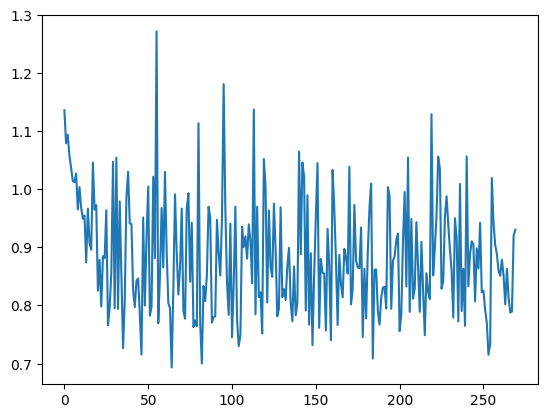

In [8]:
plt.plot(lossi)

In [27]:
evaluate(trainloader,model,criterion,DEVICE)

100%|██████████| 810/810 [00:32<00:00, 24.98it/s]


(0.239690892977847,
 {'precision': 0.8500430124266133,
  'recall': 0.819064582861092,
  'f1': 0.8318396606280883},
 tensor([2., 1., 2.,  ..., 2., 2., 1.]),
 tensor([2., 1., 2.,  ..., 2., 2., 1.]),
 tensor([[0.0273, 0.0032, 0.9696],
         [0.0039, 0.9223, 0.0738],
         [0.2593, 0.0166, 0.7241],
         ...,
         [0.0134, 0.0019, 0.9847],
         [0.0248, 0.0127, 0.9625],
         [0.0282, 0.7436, 0.2282]]))

In [28]:
evaluate(devloader,model,criterion,DEVICE)

100%|██████████| 270/270 [00:10<00:00, 26.15it/s]


(0.51220224118895,
 {'precision': 0.7890485584031975,
  'recall': 0.687727033487044,
  'f1': 0.7028291401303455},
 tensor([2., 2., 2.,  ..., 1., 1., 2.]),
 tensor([2., 1., 2.,  ..., 1., 1., 1.]),
 tensor([[0.0554, 0.0116, 0.9330],
         [0.0068, 0.7725, 0.2207],
         [0.0314, 0.4542, 0.5145],
         ...,
         [0.0023, 0.9777, 0.0200],
         [0.0140, 0.9517, 0.0343],
         [0.0029, 0.9820, 0.0151]]))

In [9]:
X,y = next(iter(devloader))

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.78 GiB total capacity; 5.12 GiB already allocated; 51.25 MiB free; 5.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

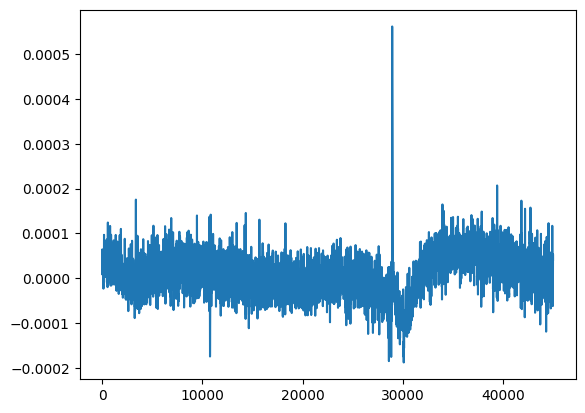

In [23]:
plt.plot(X[0,:])
y.argmax(axis=1)
model(X.to(DEVICE))

In [19]:
torch.softmax(model(X.to(DEVICE)),dim=1).argmax(axis=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.78 GiB total capacity; 5.10 GiB already allocated; 61.94 MiB free; 5.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
cohort = f'B'
subject = f'2'
raw = read_raw_edf(f'./data/Cohort{cohort}/recordings/{cohort}{subject}.edf')
eeg = raw.get_data('EEG1').squeeze()
plt.plot(np.linspace(0,1,512*10),eeg[:512*10])
eeg = resample(eeg,86400*500)
plt.plot(np.linspace(0,1,500*10),eeg[:500*10])
X = torch.from_numpy(eeg.reshape(-1,5000)).float()
df = pd.read_csv(f'data/Cohort{cohort}/scorings/{cohort}{subject}.csv',header=None)
cat = pd.Categorical(df[1])
cats = cat.categories
print(cats)
labels = np.array([[a]*2000 for a in list(cat.codes)]).flatten()
y = torch.from_numpy(labels.reshape(-1,5000)).mode(dim=1).values
y[torch.where(y == 0)[0]] = 5
y[torch.where(y == 1)[0]] = 3
y[torch.where(y == 2)[0]] = 4
y[torch.where(y == 3)[0]] = 1
y[torch.where(y == 4)[0]] = 0
y[torch.where(y == 5)[0]] = 2
y = torch.nn.functional.one_hot(y.long()).float()
# ['1', '2', '3', 'n', 'r', 'w']

In [ ]:
spindle_psds = pd.DataFrame()
for signal,label in zip(X,y.argmax(axis=1)):
    freq,psd = compute_psd(signal,500)
    idx = np.where(freq < 25)[0]
    freq,psd = freq[idx],psd[idx]
    spindle_psds = spindle_psds.append(pd.Series(psd,name=f'{label}'))

In [ ]:
sns.lineplot(data=spindle_psds.reset_index().melt(id_vars='index'),x='variable',y='value',hue='index')
plt.yscale('log')

In [ ]:
# X,y = load_eeg_label_pair()
psds = pd.DataFrame()
for signal,label in zip(X,y.argmax(axis=1)):
    freq,psd = compute_psd(signal,500)
    idx = np.where(freq < 25)[0]
    freq,psd = freq[idx],psd[idx]
    psds = psds.append(pd.Series(psd,name=f'{label}'))

In [ ]:
sns.lineplot(data=psds.reset_index().melt(id_vars='index'),x='variable',y='value',hue='index')
plt.yscale('log')

In [ ]:
paradoxical = spindle_psds.reset_index(drop=True)[spindle_psds.reset_index()['index'] == '0']
paradoxical['type'] = 'spindle'
tmp = psds.reset_index(drop=True)[psds.reset_index()['index'] == '0']
tmp['type'] = 'ekyn'

In [ ]:
tmp = psds.reset_index(drop=True)[psds.reset_index()['index'] == '0']
tmp['type'] = 'B1'

In [ ]:
sns.lineplot(data=pd.concat([paradoxical,tmp]).melt(id_vars='type'),x='variable',y='value',hue='type')
plt.yscale('log')

In [ ]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../gandalfs/gandalf_0/best_model.pt',map_location='cpu'))
model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
dataloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
loss,metrics,y_true,y_pred,logits = evaluate(dataloader,model,criterion,DEVICE)

In [ ]:
cm_grid(y_true,y_pred)